# Nutritional Inequality and Food Prices  

## Introduction  

Nutritional inequality refers to disparities in diet quality and access to healthy food across different socioeconomic groups. Rising food prices, food deserts, and lack of nutrition education contribute to this issue, affecting millions of Americans. As of 2025, **around 40 million Americans** experience food insecurity, with many turning to cheaper, less nutritious options due to affordability and accessibility challenges.  

In this project, we explore **how food prices impact dietary choices and accessibility across different regions and income levels**. Our research focuses on:  

- **Comparing** the cost of nutrient-dense foods (fruits, vegetables) versus processed foods  
- **Analyzing** geographical disparities in food availability (food deserts)  
- **Investigating** the role of socioeconomic factors in nutritional choices 

To address these questions, we leverage publicly available datasets from **USDA, BLS, FAO, and Kaggle**, integrating statistical analysis and visualization techniques. Our goal is to uncover meaningful insights into the systemic causes of nutritional inequality and potential policy interventions.  

---  
### Notebook Workflow  
🔹 **Data Wrangling:** Cleaning and preprocessing datasets  
🔹 **Combining Data:** Merging multiple sources for comprehensive analysis  
🔹 **Statistical Analysis:** Identifying correlations between food prices, income, and access  
🔹 **Visualization:** Presenting trends and disparities through charts and maps  

This notebook serves as a prototype for our analysis, demonstrating key data transformations, exploratory statistics, and preliminary findings. 🚀  

In [2]:
# Load in packages

import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
# others

In [3]:
# Load in datasets
folder_path = 'project data/'

historical_changes_consumer_price = pd.read_csv(folder_path + '(historical) changes_consumer_price.csv')
historical_producer_price_changes = pd.read_csv(folder_path + '(historical) producer_price_changes.csv')
state_and_county = pd.read_csv(folder_path + 'StateAndCountyData.csv')
variable_list = pd.read_csv(folder_path + 'VariableList.csv')

## Data Wrangling 

### For CPI + PPI 

In [5]:
historical_producer_price_changes.head()

,Producer Price Index item,Year,Percent change
0,Unprocessed foodstuffs and feedstuffs,1974,5.2
1,Unprocessed foodstuffs and feedstuffs,1975,1.3
2,Unprocessed foodstuffs and feedstuffs,1976,-0.8
3,Unprocessed foodstuffs and feedstuffs,1977,0.9
4,Unprocessed foodstuffs and feedstuffs,1978,12.6


In [6]:
## Showing data
historical_changes_consumer_price.head()

,Consumer Price Index item,Year,Percent change
0,All food,1974,14.3
1,All food,1975,8.5
2,All food,1976,3.0
3,All food,1977,6.3
4,All food,1978,9.9


In [7]:
# cleaning historical producer price changes + consumer price 

historical_producer_price_changes['Year'] = pd.to_numeric(historical_producer_price_changes['Year'], errors='coerce')
historical_producer_price_changes['Percent change'] = pd.to_numeric(historical_producer_price_changes['Percent change'], errors='coerce')
historical_changes_consumer_price['Year'] = pd.to_numeric(historical_changes_consumer_price['Year'], errors='coerce')
historical_changes_consumer_price['Percent change'] = pd.to_numeric(historical_changes_consumer_price['Percent change'], errors='coerce')

historical_producer_price_changes = historical_producer_price_changes.dropna()
historical_changes_consumer_price = historical_changes_consumer_price.dropna()

def categorize_food(item):
    item = item.lower()
    if "farm-level" in item:
        return "Farm Level"
    elif "wholesale" in item:
        return "Wholesale"
    elif "unprocessed" in item:
        return "Unprocessed"
    elif "processed" in item:
        return "Processed"
    elif "finished" in item:
        return "Finished"
    else:
        return "Other"

# create new category 
historical_producer_price_changes['Category'] = historical_producer_price_changes['Producer Price Index item'].apply(categorize_food)

print(historical_changes_consumer_price['Consumer Price Index item'].unique())

print(historical_producer_price_changes['Producer Price Index item'].unique())

# creating map as categories differ 
mapping = {
    "Wholesale beef": "Beef and veal",
    "Farm-level cattle": "Beef and veal",
    "Wholesale pork": "Pork",
    "Wholesale poultry": "Poultry",
    "Farm-level eggs": "Eggs",
    "Wholesale dairy": "Dairy products",
    "Farm-level milk": "Dairy products",
    "Farm-level soybeans": "Fats and oils",
    "Wholesale fats and oils": "Fats and oils",
    "Farm-level fruit": "Fresh fruits",
    "Farm-level vegetables": "Fresh vegetables",
    "Farm-level wheat": "Cereals and bakery products",
    "Wholesale wheat flour": "Cereals and bakery products",
    "Unprocessed foodstuffs and feedstuffs": "All food",
    "Processed foods and feeds": "All food",
    "Finished consumer foods": "All food",
}

historical_producer_price_changes['Mapped Category'] = historical_producer_price_changes['Producer Price Index item'].map(mapping)

# merge data set 

cpi_ppi = pd.merge(
    historical_changes_consumer_price,
    historical_producer_price_changes,
    left_on=['Year', 'Consumer Price Index item'],
    right_on=['Year', 'Mapped Category'],
    suffixes=('_consumer', '_producer')
)

# remove columns 

cpi_ppi = cpi_ppi.drop(columns=['Producer Price Index item', 'Mapped Category'])
cpi_ppi = cpi_ppi.dropna()

# display 

print(cpi_ppi.head())

['All food' 'Food away from home' 'Food at home'
 'Meats, poultry, and fish' 'Meats' 'Beef and veal' 'Pork' 'Other meats'
 'Poultry' 'Fish and seafood' 'Eggs' 'Dairy products' 'Fats and oils'
 'Fruits and vegetables' 'Fresh fruits and vegetables' 'Fresh fruits'
 'Fresh vegetables' 'Processed fruits and vegetables' 'Sugar and sweets'
 'Cereals and bakery products' 'Nonalcoholic beverages' 'Other foods']
['Unprocessed foodstuffs and feedstuffs' 'Processed foods and feeds'
 'Finished consumer foods' 'Farm-level cattle' 'Wholesale beef'
 'Wholesale pork' 'Wholesale poultry' 'Farm-level eggs' 'Farm-level milk'
 'Wholesale dairy' 'Farm-level soybeans' 'Wholesale fats and oils'
 'Farm-level fruit' 'Farm-level vegetables' 'Farm-level wheat'
 'Wholesale wheat flour']
  Consumer Price Index item  Year  Percent change_consumer  \
0                  All food  1974                     14.3   
1                  All food  1974                     14.3   
2                  All food  1974            

### Stat + County Data Set

In [9]:
## Variable list
variable_list.head()

,Variable_Name,Category_Name,Category_Code,Subcategory_Name,Variable_Code,Geography,Units
0,"Population, low access to store, 2010",Access and Proximity to Grocery Store,ACCESS,Overall,LACCESS_POP10,CNTY10,Count
1,"Population, low access to store, 2015",Access and Proximity to Grocery Store,ACCESS,Overall,LACCESS_POP15,CNTY10,Count
2,"Population, low access to store (% change), 20...",Access and Proximity to Grocery Store,ACCESS,Overall,PCH_LACCESS_POP_10_15,CNTY10,% change
3,"Population, low access to store (%), 2010",Access and Proximity to Grocery Store,ACCESS,Overall,PCT_LACCESS_POP10,CNTY10,Percent
4,"Population, low access to store (%), 2015",Access and Proximity to Grocery Store,ACCESS,Overall,PCT_LACCESS_POP15,CNTY10,Percent


In [10]:
## State + County Data set 
state_and_county.head()

,FIPS,State,County,Variable_Code,Value
0,1001,AL,Autauga,LACCESS_POP10,18428.439690
1,1001,AL,Autauga,LACCESS_POP15,17496.693040
2,1001,AL,Autauga,PCH_LACCESS_POP_10_15,-5.056026
3,1001,AL,Autauga,PCT_LACCESS_POP10,33.769657
4,1001,AL,Autauga,PCT_LACCESS_POP15,32.062255


## Statistical Analysis

In [12]:
## hypothesis test

## Visualization

Producer Data Summary:
               Producer Price Index item  Year  Percent change     Category  \
0  Unprocessed foodstuffs and feedstuffs  1974             5.2  Unprocessed   
1  Unprocessed foodstuffs and feedstuffs  1975             1.3  Unprocessed   
2  Unprocessed foodstuffs and feedstuffs  1976            -0.8  Unprocessed   
3  Unprocessed foodstuffs and feedstuffs  1977             0.9  Unprocessed   
4  Unprocessed foodstuffs and feedstuffs  1978            12.6  Unprocessed   

  Mapped Category  
0        All food  
1        All food  
2        All food  
3        All food  
4        All food  


/Users/abigaileun/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


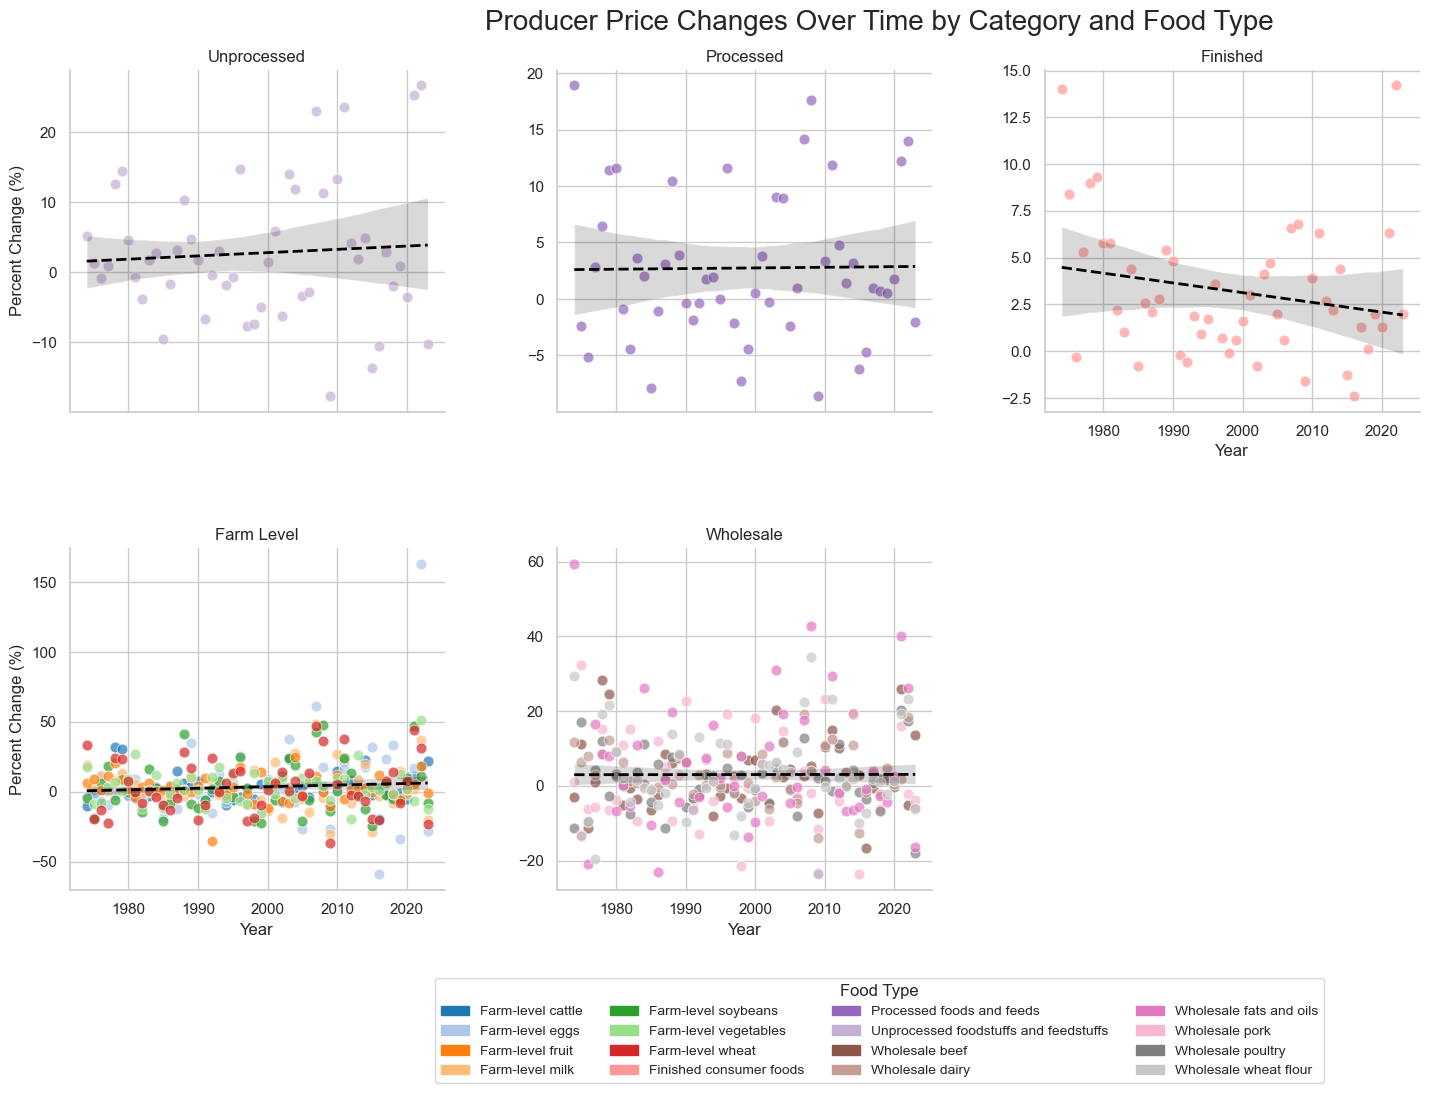

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns
## Producer Data Visualization 

print("Producer Data Summary:")
print(historical_producer_price_changes.head())
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

# Make sure your data is loaded into this DataFrame
# historical_producer_price_changes = pd.read_csv(...) or however you're loading it

# Set style
sns.set(style="whitegrid")

# Sort food types to keep legend clean and consistent
unique_food_types = sorted(historical_producer_price_changes["Producer Price Index item"].unique())

# Assign colors using tab20 palette
palette = sns.color_palette("tab20", len(unique_food_types))
color_dict = dict(zip(unique_food_types, palette))

# Create the FacetGrid (no legend from here)
g = sns.FacetGrid(
    historical_producer_price_changes,
    col="Category",
    col_wrap=3,
    height=5,
    aspect=1.2,
    hue="Producer Price Index item",
    palette=color_dict,
    sharey=False,
    legend_out=True  # turn off auto-legend
)

# Scatter plots
g.map_dataframe(
    sns.scatterplot,
    x="Year",
    y="Percent change",
    alpha=0.7,
    s=60
)

# Add regression lines per subplot
for ax, category in zip(g.axes.flat, historical_producer_price_changes['Category'].unique()):
    data = historical_producer_price_changes[
        historical_producer_price_changes['Category'] == category
    ]
    sns.regplot(
        data=data,
        x="Year",
        y="Percent change",
        scatter=False,
        ax=ax,
        color='black',
        ci=95,
        line_kws={'linewidth': 2, 'linestyle': '--'}
    )
    ax.set_title(category, fontsize=14)
    sns.despine(ax=ax)

# Axis and layout adjustments
g.set_axis_labels("Year", "Percent Change (%)")
g.set_titles("{col_name}")
g.fig.subplots_adjust(top=0.92, bottom=0.1, left=0.05, right=0.8, hspace=0.4, wspace=0.3)
g.fig.suptitle("Producer Price Changes Over Time by Category and Food Type", fontsize=20)

# Manually build legend patches
handles = [
    mpatches.Patch(color=color_dict[ftype], label=ftype)
    for ftype in unique_food_types
]

# Add full manual legend
g.fig.legend(
    handles=handles,
    title="Food Type",
    loc='lower center',
    bbox_to_anchor=(0.5, -0.10),  # push this value down as much as you want
    frameon=True,
    fontsize=10,
    title_fontsize=12,
    ncol=4  # you can increase this if you want a tighter, wider legend
)


plt.show()


While this visualiation does not reveal a strong linear relationship between Producer Price Changes Over Time when faceted by Category and Food Type, it suggests that generally Producer Price Index percentage changes for Farm Level and Wholesale Products experience more drastic changes compared to Processed. This could suggest that perhaps Processed Foods experience less drastic changes in profits for producers, and thus could drive for preference for Processed Foods from a Producer's standpoint as the Producer Price Index appears more stable. 

/Users/abigaileun/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/abigaileun/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


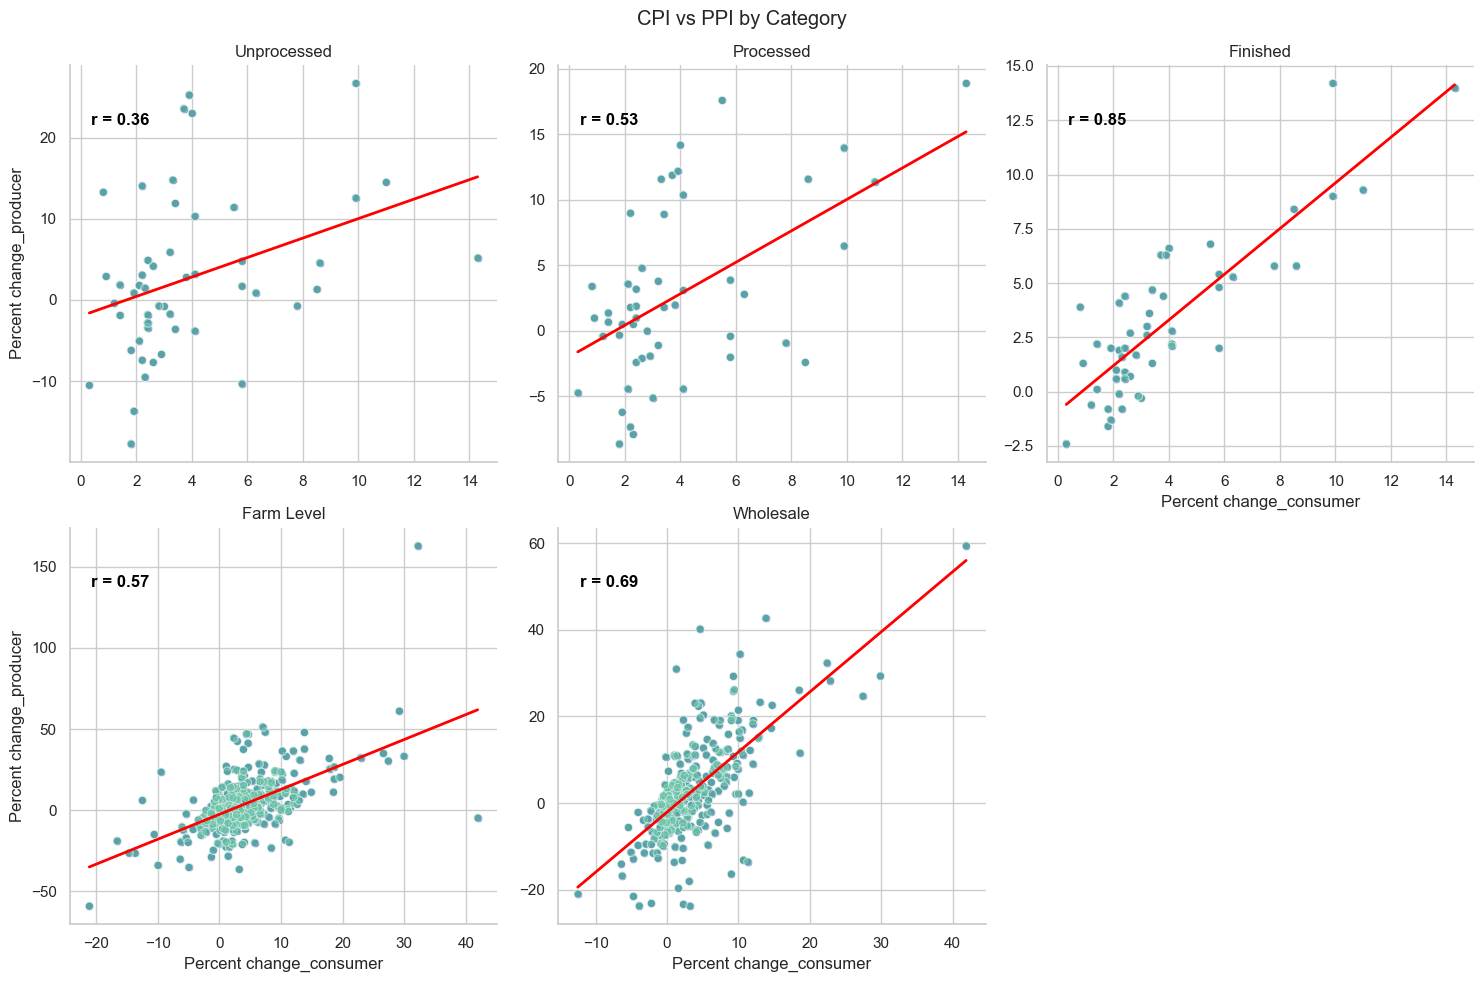

In [82]:
## PPI vs CPI 

g = sns.FacetGrid(cpi_ppi, col="Category", col_wrap=3, height=5, sharex=False, sharey=False)
g.map_dataframe(sns.scatterplot, x="Percent change_consumer", y="Percent change_producer")

# Adding titles and labels
g.set_axis_labels("Consumer Price Index (CPI) Percent Change", "Producer Price Index (PPI) Percent Change")
g.set_titles("{col_name}")

plt.subplots_adjust(top=0.9)
g.fig.suptitle("CPI vs PPI by Category")

for ax, category in zip(g.axes.flat, cpi_ppi["Category"].unique()):
    data = cpi_ppi[cpi_ppi["Category"] == category]
    sns.regplot(data=data, x="Percent change_consumer", y="Percent change_producer", ax=ax, 
                scatter=False, color='red', ci=None, line_kws={'linewidth': 2})

from scipy.stats import pearsonr

for ax, category in zip(g.axes.flat, cpi_ppi["Category"].unique()):
    data = cpi_ppi[cpi_ppi["Category"] == category]
    corr, _ = pearsonr(data["Percent change_consumer"], data["Percent change_producer"])
    ax.annotate(f"r = {corr:.2f}", xy=(0.05, 0.85), xycoords="axes fraction", fontsize=12, fontweight="bold", color="black")

g.map_dataframe(sns.scatterplot, x="Percent change_consumer", y="Percent change_producer", alpha=0.6, hue="Category", palette="Set2")

plt.show()


From this visualization, we can see that for Farm Level nd Finished Products, theres a clear positive moderately strong linear relationship between CPI Change and PPI Change, however, the slope is difficult to compare due to differing interval values. In this data set, "Finished" refers to packaged, ready to eat goods like cookies, snacks, etc. On the other hand, farm level is typical raw products like meats, produce, etc. sourced directly from farms. Thus, our next step would be to create a linear regression model to directly understand these slopes and perhaps group "Finished" and "Processed" products into an "Unhealthy" food category, and "Farm Level" and "Unprocessed" together into a Healthy category. 

In [18]:
# from scipy.stats import pearsonr

# # Set style
# sns.set(style="whitegrid")

# # Define colors for health categories
# colors = {"Healthy": "green", "Unhealthy": "red", "Other": "gray"}

# # Create the facet grid
# g = sns.FacetGrid(cpi_ppi, col="Health Category", height=6, sharex=True, sharey=True, palette=colors)
# g.map_dataframe(sns.scatterplot, x="Percent change_consumer", y="Percent change_producer", alpha=0.6, edgecolor="black")

# # Add regression lines & correlation coefficients
# for ax, category in zip(g.axes.flat, cpi_ppi['Health Category'].unique()):
#     data = cpi_ppi[cpi_ppi['Health Category'] == category]
    
#     # Regression line with confidence interval
#     sns.regplot(data = data, x = "Percent change_consumer", y = "Percent change_producer", ax = ax, 
#                 scatter = False, color=colors[category], ci = 95, line_kws = {'linewidth': 2})
    
#     # calculate Pearson correlation
#     corr, _ = pearsonr(data['Percent change_consumer'], data['Percent change_producer'])
#     ax.text(0.05, 0.9, f"r = {corr:.2f}", transform=ax.transAxes, fontsize=12, fontweight="bold", color="black")

# # Adjust titles & labels
# g.set_axis_labels("CPI Percent Change", "PPI Percent Change")
# g.set_titles("{col_name}")

# # Improve title positioning
# plt.subplots_adjust(top=0.85)
# g.fig.suptitle("CPI vs PPI - Healthy vs Unhealthy Foods", fontsize=16, fontweight="bold")

# # Show the figure
# plt.show()

From here, we decided to look at the linear regression models directly. 

In [20]:
## linear Regression Models 

# categories = cpi_ppi['Health Category'].unique()

# for category in categories:

#     data = cpi_ppi[cpi_ppi['Health Category'] == category]

#     slope, intercept, r_value, p_value, std_err = stats.linregress(
#         data['Percent change_consumer'],
#         data['Percent change_producer']
#     )

#     # Print results
#     print(f"Category: {category}")
#     print(f"  Slope: {slope:.4f}")
#     print(f"  Intercept: {intercept:.4f}")
#     print(f"  R-squared: {r_value**2:.4f}")
#     print(f"  P-value: {p_value:.4e}")
#     print(f"  Standard Error: {std_err:.4f}")
#     print("-" * 50)

Our linear regression models suggest that for Healthy foods, for every one percent increase in CPI, we would expect, on average, for the PPI to increase by around 1.53%, while for Unhealthy foods, for every one percent increase in CPI, we would expect, on average, for the PPI to increase by 1.13%. This could possibly suggest that producers make more profit when the price for consumers are increased for Healthy foods compared to Unhealthy foods, and thus producers may be incentivized to increase the price of Healthy foods over those of Unhealthy. 

In [22]:
# sns.set(style="whitegrid")

# # calculate statistics 
# median_healthy = cpi_ppi[cpi_ppi['Health Category'] == 'Healthy']['Percent change_consumer'].median()
# median_unhealthy = cpi_ppi[cpi_ppi['Health Category'] == 'Unhealthy']['Percent change_consumer'].median()
# mean_healthy = cpi_ppi[cpi_ppi['Health Category'] == 'Healthy']['Percent change_consumer'].mean()
# mean_unhealthy = cpi_ppi[cpi_ppi['Health Category'] == 'Unhealthy']['Percent change_consumer'].mean()

# # figure size
# plt.figure(figsize=(12, 6))

# # healthy foods histogram
# plt.subplot(1, 2, 1)
# sns.histplot(data=cpi_ppi[cpi_ppi['Health Category'] == 'Healthy'], 
#              x='Percent change_consumer', 
#              kde=False, 
#              bins=20, 
#              color='green')

# # add median and mean indicators
# plt.axvline(median_healthy, color='black', linestyle='dashed', linewidth=1.5, label=f'Median: {median_healthy:.2f}')
# plt.axvline(mean_healthy, color='red', linestyle='dotted', linewidth=1.5, label=f'Mean: {mean_healthy:.2f}')
# plt.legend()

# plt.title('Consumer Price Index (CPI) - Healthy Foods')
# plt.xlabel('CPI Percent Change')
# plt.ylabel('Frequency')

# # unhealthy foods histogram
# plt.subplot(1, 2, 2)
# sns.histplot(data=cpi_ppi[cpi_ppi['Health Category'] == 'Unhealthy'], 
#              x='Percent change_consumer', 
#              kde=False, 
#              bins=20, 
#              color='blue')

# # Find global min and max for x-axis limits
# global_min = cpi_ppi['Percent change_consumer'].min()
# global_max = cpi_ppi['Percent change_consumer'].max()
# plt.xlim(global_min, global_max)

# plt.title('Consumer Price Index (CPI) - Unhealthy Foods')
# plt.xlabel('CPI Percent Change')
# plt.ylabel('Frequency')

# plt.tight_layout()
# plt.show()

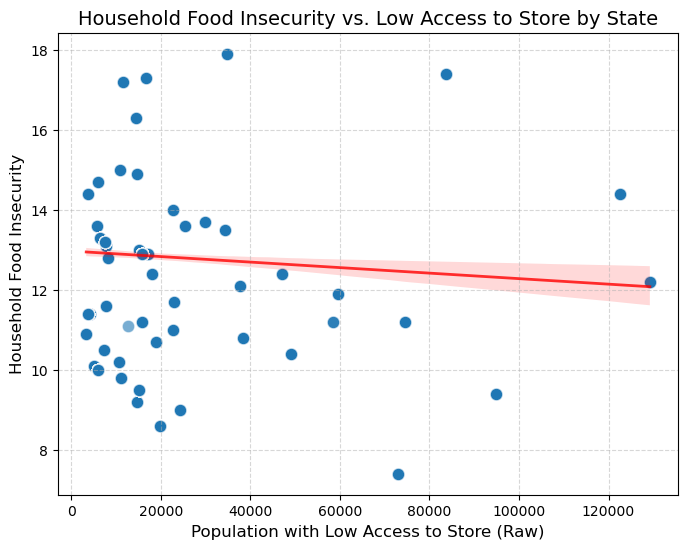

In [23]:
# Maybe disregard- unsure why household food insecurity is negative 

# Household food insecurity (%), three-year average, 2015-17 vs Population, low access to store, 2015

# Filter low access population data
filtered_data_low_access = state_and_county[state_and_county['Variable_Code'] == 'LACCESS_POP15'].copy()
filtered_data_low_access['Low Access Population'] = pd.to_numeric(filtered_data_low_access['Value'], errors='coerce')

state_avg_low_access = filtered_data_low_access.groupby('State')['Low Access Population'].mean().reset_index()

# Filter household insecurity data
filtered_data_insecurity = state_and_county[state_and_county['Variable_Code'] == 'FOODINSEC_15_17'][['County', 'State', 'Value']].copy()
filtered_data_insecurity.rename(columns={'Value': 'Household Insecurity'}, inplace=True)
filtered_data_insecurity['Household Insecurity'] = pd.to_numeric(filtered_data_insecurity['Household Insecurity'], errors='coerce')

# Merge the two datasets on State to align counties correctly
merged_food_insecurity_low_access = filtered_data_insecurity.merge(state_avg_low_access, on='State', how='left')

# Create scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=merged_food_insecurity_low_access,
    x='Low Access Population',
    y='Household Insecurity',
    # color='dodgerblue',
    alpha=0.6,  # Reduce opacity for overlap handling
    s=80  # Increase point size for better visibility
)

# Add a trend line
sns.regplot(
    data=merged_food_insecurity_low_access,
    x='Low Access Population',
    y='Household Insecurity',
    scatter=False,  # Hide scatter points for the regression plot
    color='red',
    ci=95,  # Confidence interval (default: 95%)
    line_kws={'linewidth': 2, 'alpha': 0.8}  # Adjust line opacity
)

# Improve labels and title
plt.title("Household Food Insecurity vs. Low Access to Store by State", fontsize=14)
plt.xlabel("Population with Low Access to Store (Raw)", fontsize=12)
plt.ylabel("Household Food Insecurity", fontsize=12)

# Add grid for better readability
plt.grid(True, linestyle="--", alpha=0.5)

plt.show()

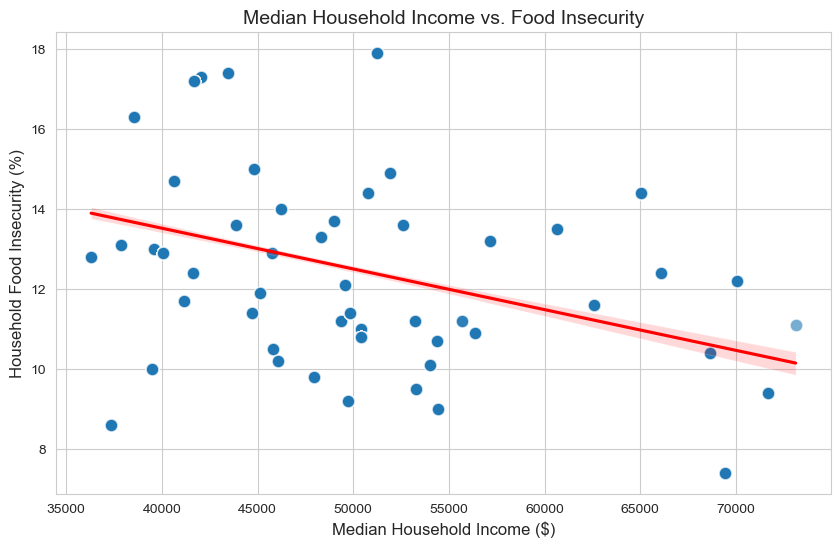

In [24]:
# median household income vs. food insecurity 

# Filter median household income 
filtered_data_income = state_and_county[state_and_county['Variable_Code'] == 'MEDHHINC15'].copy()
filtered_data_income['Median Household Income'] = pd.to_numeric(filtered_data_income['Value'], errors='coerce')

state_avg_median_income = filtered_data_income.groupby('State')['Median Household Income'].median().reset_index()

# Merge the two datasets on State to align counties correctly
merged_median_income_food_insecurity = filtered_data_insecurity.merge(state_avg_median_income, on='State', how='left')

# Set figure size and style
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Scatter plot
sns.scatterplot(
    data=merged_median_income_food_insecurity,  
    x='Median Household Income',  
    y='Household Insecurity',  
    alpha=0.6,  # Reduce opacity for overlap handling
    s=80  # Increase point size for better visibility
)

# Add regression line
sns.regplot(
    data=merged_median_income_food_insecurity,  
    x='Median Household Income',  
    y='Household Insecurity',  
    scatter=False,  # Hide original points
    line_kws={'color': 'red'}  # Trend line in red
)

# Adjust x-axis labels to thousands (K)
# plt.xticks(ticks=plt.xticks()[0], labels=[f"{int(tick/1000)}K" for tick in plt.xticks()[0]])

# Titles and labels
plt.title("Median Household Income vs. Food Insecurity", fontsize=14)
plt.xlabel("Median Household Income ($)", fontsize=12)
plt.ylabel("Household Food Insecurity (%)", fontsize=12)

# Show plot
plt.show()

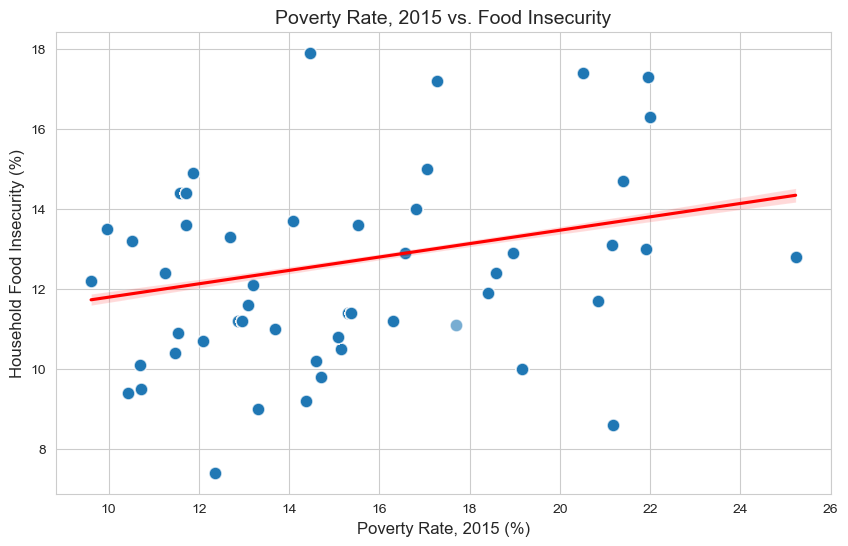

In [25]:
# poverty rate vs. food insecurity 

# Filter median household income 
filtered_data_poverty = state_and_county[state_and_county['Variable_Code'] == 'POVRATE15'].copy()
filtered_data_poverty['Poverty Rate, 2015'] = pd.to_numeric(filtered_data_poverty['Value'], errors='coerce')

state_avg_poverty_rate = filtered_data_poverty.groupby('State')['Poverty Rate, 2015'].mean().reset_index()

# Merge the two datasets on State to align counties correctly
merged_poverty_rate_food_insecurity = filtered_data_insecurity.merge(state_avg_poverty_rate, on='State', how='left')

# Set figure size and style
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Scatter plot
sns.scatterplot(
    data=merged_poverty_rate_food_insecurity,  
    x='Poverty Rate, 2015',  
    y='Household Insecurity',  
    alpha=0.6,  # Reduce opacity for overlap handling
    s=80  # Increase point size for better visibility
)

# Add regression line
sns.regplot(
    data=merged_poverty_rate_food_insecurity,  
    x='Poverty Rate, 2015',  
    y='Household Insecurity',  
    scatter=False,  # Hide original points
    line_kws={'color': 'red'}  # Trend line in red
)

# Adjust x-axis labels to thousands (K)
# plt.xticks(ticks=plt.xticks()[0], labels=[f"{int(tick/1000)}K" for tick in plt.xticks()[0]])

# Titles and labels
plt.title("Poverty Rate, 2015 vs. Food Insecurity", fontsize=14)
plt.xlabel("Poverty Rate, 2015 (%)", fontsize=12)
plt.ylabel("Household Food Insecurity (%)", fontsize=12)

# Show plot
plt.show()

In [26]:
# linear regression

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# merge
predictors_df = state_avg_median_income.merge(state_avg_poverty_rate, on='State')
final_df = filtered_data_insecurity.merge(predictors_df, on='State', how='left')

# drop NA 
final_df = final_df.dropna(subset=['Household Insecurity', 'Median Household Income', 'Poverty Rate, 2015'])

# set up 
X = final_df[['Median Household Income', 'Poverty Rate, 2015']]
y = final_df['Household Insecurity']

# fit
model = LinearRegression()
model.fit(X, y)

# predictions
y_pred = model.predict(X)

# eval
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)

# compare
y_baseline = np.full_like(y, np.median(y), dtype=np.float64)
baseline_mse = mean_squared_error(y, y_baseline)
baseline_r2 = r2_score(y, y_baseline)

# results
print("Model MSE:", mse, "R²:", r2)
print("Baseline MSE:", baseline_mse, "R²:", baseline_r2)

Model MSE: 4.363983359945254 R²: 0.09314056054652275
Baseline MSE: 4.839840916321985 R²: -0.0057452236652935085


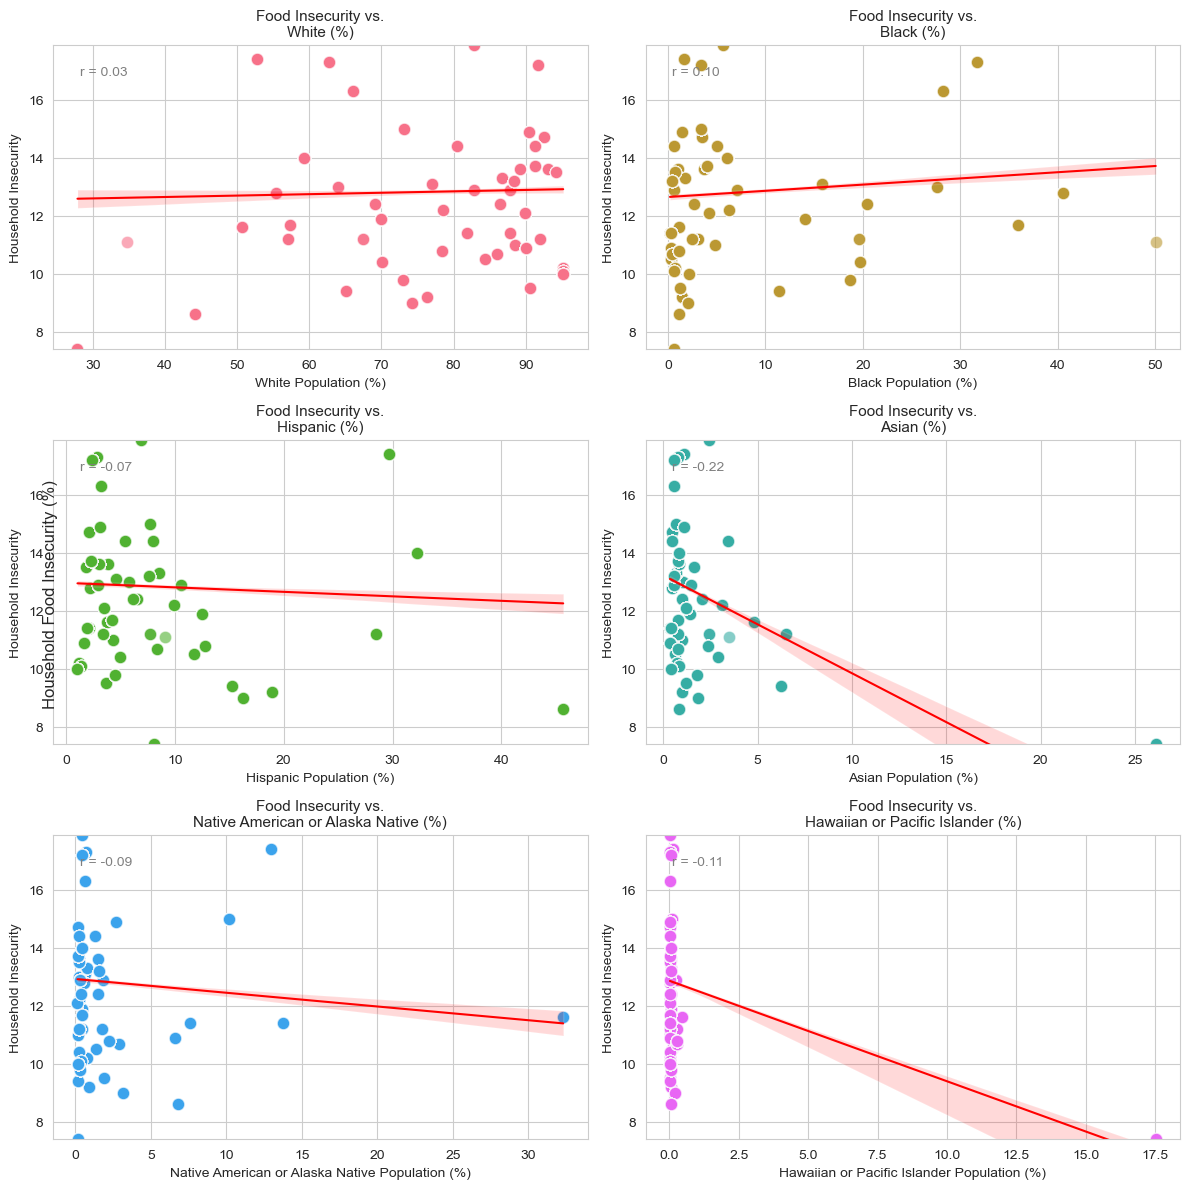

In [27]:
# Function to filter and rename race data
def get_race_data(var_code, race_name):
    df = state_and_county[state_and_county['Variable_Code'] == var_code].copy()
    df[race_name] = pd.to_numeric(df['Value'], errors='coerce')
    return df[['State', race_name]].groupby('State').mean().reset_index()

# Get racial percentages
white_data = get_race_data('PCT_NHWHITE10', 'White')
black_data = get_race_data('PCT_NHBLACK10', 'Black')
hispanic_data = get_race_data('PCT_HISP10', 'Hispanic')
asian_data = get_race_data('PCT_NHASIAN10', 'Asian')
native_american_data = get_race_data('PCT_NHNA10', 'Native American or Alaska Native')
hpi_data = get_race_data('PCT_NHPI10', 'Hawaiian or Pacific Islander')

# Merge all racial data into one DataFrame
state_avg_race = white_data
for df in [black_data, hispanic_data, asian_data, native_american_data, hpi_data]:
    state_avg_race = state_avg_race.merge(df, on='State', how='left')

# Merge with food insecurity data
merged_data_race = filtered_data_insecurity.merge(state_avg_race, on='State', how='left')

# Set figure size and style
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
axes = axes.flatten()
palette = sns.color_palette("husl", 6)

# Standardize Y-axis range
ymin = merged_data_race['Household Insecurity'].min()
ymax = merged_data_race['Household Insecurity'].max()

# Loop through racial groups to create subplots
for i, race in enumerate(['White', 'Black', 'Hispanic', 'Asian', 'Native American or Alaska Native', 'Hawaiian or Pacific Islander']):
    sns.scatterplot(
        data=merged_data_race,
        x=race,
        y='Household Insecurity',
        ax=axes[i],
        color=palette[i],
        alpha=0.6,
        s=80
    )
    
    # Add regression line
    sns.regplot(
        data=merged_data_race,
        x=race,
        y='Household Insecurity',
        scatter=False,
        ax=axes[i],
        line_kws={'color': 'red', 'linewidth': 1.5},
        ci=95
    )

    # Calculate correlation coefficient
    corr, _ = pearsonr(merged_data_race[race].dropna(), merged_data_race['Household Insecurity'].dropna())
    axes[i].text(0.05, 0.9, f'r = {corr:.2f}', transform=axes[i].transAxes, fontsize=10, color='gray')

    # Standardize y-axis range
    axes[i].set_ylim(ymin, ymax)

    # Improve titles and labels
    axes[i].set_title(f'Food Insecurity vs.\n{race} (%)', fontsize=11)
    axes[i].set_xlabel(f'{race} Population (%)')

# Add shared y-axis label
fig.text(0.04, 0.5, 'Household Food Insecurity (%)', va='center', rotation='vertical', fontsize=12)

plt.tight_layout()
plt.show()